In [1]:
#%matplotlib notebook
#%matplotlib qt
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('ticks')

from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


# Whole dataset

In [2]:
dataset_df = pd.read_csv('./datasets/OUTPUT_WBI_exposer_cyclones_v2.csv',sep=",")
print('size of the whole dataset: {}'.format(len(dataset_df)))
print(list(dataset_df.columns))

size of the whole dataset: 1005
['Unnamed: 0', 'SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE', 'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', 'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$', 'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', 'Adjusted savings: education expenditure (% of GNI)', 'Rural population (% of total population)', 'Income_level_Final', 'TOTAL_AFFECTED', 'Population, total', 'Population_2000', 'Population_2005', 'Population

# First filter
Here I made a selection of the columns I think contain the most important information

In [3]:
selected_columns = ['YEAR',
                    'ISO_TIME','TOTAL_HRS','USA_SSHS','V_LAND_KN',
                    'pop_max_34_adj','pop_max_50_adj','pop_max_64_adj',                    
                    'ISO','GDP per capita (constant 2010 US$)','GDP growth (annual %)','Net flows from UN agencies US$','Income_level_Final',                         
                    'Air transport, freight (million ton-km)','Arable land (hectares per person)','Cereal yield (kg per hectare)','Food production index (2004-2006 = 100)','Life expectancy at birth, total (years)',
                    'TOTAL_AFFECTED','CPI','TOTAL_DAMAGE_(000$)','TOTAL_DEATHS']
df1 = dataset_df[selected_columns]
df1.sort_values(by=['YEAR'],inplace=True)
df1.reset_index(drop=True,inplace=True)

# Some preprocessing 
(see Xavier's comments on USA_SSHS & CPI in the slack channels)

In [4]:
#Xavier's observations
df1['USA_SSHS']=df1['USA_SSHS'].replace(-5,np.nan)
df1['Income_level_Final']=df1['Income_level_Final'].replace('Low',1)
df1['Income_level_Final']=df1['Income_level_Final'].replace('Low_Middle',2)
df1['Income_level_Final']=df1['Income_level_Final'].replace('High_Middle',3)
df1['Income_level_Final']=df1['Income_level_Final'].replace('High',4)
df1['TOTAL_DAMAGE_(000$)_adj']= df1['TOTAL_DAMAGE_(000$)']/df1['CPI']
df1['TOTAL_DAMAGE_(000$)_adj']= df1['TOTAL_DAMAGE_(000$)_adj'].replace(0, np.nan)

#Since these quantities span a large range of values, we will use ln(pop_max). 
df1['pop_max_34_adj']=df1['pop_max_34_adj'].replace(0,np.nan)
df1['pop_max_50_adj']=df1['pop_max_50_adj'].replace(0,np.nan)
df1['pop_max_64_adj']=df1['pop_max_64_adj'].replace(0,np.nan)
df1['Air transport, freight (million ton-km)']=df1['Air transport, freight (million ton-km)'].replace(0,np.nan)
#Here we get rid of 'Net flows' < 0 (only two records which look very suspicious)
df1 = df1[df1['Net flows from UN agencies US$']>=0]
df1['Net flows from UN agencies US$']=df1['Net flows from UN agencies US$'].replace(0,np.nan)

This is to see the amount of NaN's

In [5]:
nans = pd.DataFrame(data=df1.isnull().sum(axis = 0).values,index=df1.columns,columns=['number'])
for idx in nans.index:
    print(idx,': ',nans.loc[idx].values[0])

YEAR :  0
ISO_TIME :  0
TOTAL_HRS :  0
USA_SSHS :  7
V_LAND_KN :  0
pop_max_34_adj :  109
pop_max_50_adj :  139
pop_max_64_adj :  209
ISO :  0
GDP per capita (constant 2010 US$) :  9
GDP growth (annual %) :  40
Net flows from UN agencies US$ :  219
Income_level_Final :  0
Air transport, freight (million ton-km) :  162
Arable land (hectares per person) :  1
Cereal yield (kg per hectare) :  9
Food production index (2004-2006 = 100) :  4
Life expectancy at birth, total (years) :  4
TOTAL_AFFECTED :  0
CPI :  0
TOTAL_DAMAGE_(000$) :  318
TOTAL_DEATHS :  133
TOTAL_DAMAGE_(000$)_adj :  318


# Transformation to pop_max -> ln(pop_max). 
This is also very useful to fight skewness

In [6]:
ln_columns = ['pop_max_34_adj','pop_max_50_adj','pop_max_64_adj',
              'GDP per capita (constant 2010 US$)','Net flows from UN agencies US$',
              'Air transport, freight (million ton-km)',
              'TOTAL_AFFECTED','TOTAL_DAMAGE_(000$)_adj','TOTAL_DEATHS']
for name in ln_columns:
    df1['ln('+name+')'] = df1.apply(lambda x: np.log(x[name]),axis=1)

In [7]:
def mean_norm(val,mean,sigma):
    val = val-mean
    val = val/sigma
    return val

# Normalization (very important!)
The normalization expressions are:
$$ x := x - mean$$
$$ x := x/std $$
After this, mean is 0 and std is 1

In [8]:
for name in df1.columns:
    if name == 'YEAR' or name == 'ISO' or name=='ISO_TIME' :
        continue
    mean = df1[name].mean()
    std  = df1[name].std()
    df1[name+'_norm']=df1.apply(lambda x: mean_norm(x[name],mean,std),axis=1) 
    
    #sanity check
    #print('{} <= {} <= {}'.format(df1[name+'_norm'].min(),name+'_norm',df1[name+'_norm'].max())) 

# Year cutoff
Here I selected storms from 1970+ (of course, you are free to use a different cutoff --or none)

In [9]:
df1=df1[df1['YEAR']>=1970]
df1.reset_index(drop=True,inplace=True)
print('size of the dataset after year cutoff: {}'.format(len(df1)))

size of the dataset after year cutoff: 959


# Second filter
As we saw above, there are a lot of NaNs (Keras is hopeless to cope with NaNs). Here we get rid of those columns with too much NaNs

In [10]:
selected_columns = ['TOTAL_HRS_norm',
                    'USA_SSHS_norm',
                    'V_LAND_KN_norm',
                    'ln(pop_max_34_adj)_norm',
                    #'ln(pop_max_50_adj)_norm',
                    #'ln(pop_max_64_adj)_norm',                 
                    'ln(GDP per capita (constant 2010 US$))_norm',
                    'GDP growth (annual %)_norm',
                    #'ln(Net flows from UN agencies US$)_norm',
                    'Income_level_Final_norm',
                    #'ln(Air transport, freight (million ton-km))_norm',
                    'Arable land (hectares per person)_norm',
                    'Cereal yield (kg per hectare)_norm',
                    'Food production index (2004-2006 = 100)_norm',
                    'Life expectancy at birth, total (years)_norm',
                    'ln(TOTAL_AFFECTED)_norm']
                    #'ln(TOTAL_DAMAGE_(000$)_adj)_norm',
                    #'ln(TOTAL_DEATHS)_norm'] 

df2 = df1[selected_columns]
print(len(df2))
print(len(df2.columns))

959
12


Amount of NaNs after second selection

In [11]:
nans = pd.DataFrame(data=df2.isnull().sum(axis = 0).values,index=df2.columns,columns=['number'])
for idx in nans.index:
    print(idx,': ',nans.loc[idx].values[0])

TOTAL_HRS_norm :  0
USA_SSHS_norm :  7
V_LAND_KN_norm :  0
ln(pop_max_34_adj)_norm :  98
ln(GDP per capita (constant 2010 US$))_norm :  9
GDP growth (annual %)_norm :  23
Income_level_Final_norm :  0
Arable land (hectares per person)_norm :  1
Cereal yield (kg per hectare)_norm :  9
Food production index (2004-2006 = 100)_norm :  4
Life expectancy at birth, total (years)_norm :  4
ln(TOTAL_AFFECTED)_norm :  0


# Third filter. 
Here we drop rows with NaNs (our aim is to retain most of the records)

In [12]:
df3 = df2.dropna(axis=0)
df3

,TOTAL_HRS_norm,USA_SSHS_norm,V_LAND_KN_norm,ln(pop_max_34_adj)_norm,ln(GDP per capita (constant 2010 US$))_norm,GDP growth (annual %)_norm,Income_level_Final_norm,Arable land (hectares per person)_norm,Cereal yield (kg per hectare)_norm,Food production index (2004-2006 = 100)_norm,"Life expectancy at birth, total (years)_norm",ln(TOTAL_AFFECTED)_norm
0,-1.777914,-0.834724,1.078850,-0.760042,-1.073004,0.182507,-0.520984,0.356426,-0.946513,-1.201951,-3.569170,-0.277527
1,1.052852,-0.834724,-1.174768,1.030482,-2.019940,3.525413,-0.520984,-0.187966,-0.790254,-2.545065,-1.593193,-0.169449
2,1.052852,2.113450,1.970624,-0.125064,-0.794567,-0.177885,-0.520984,-0.162121,-1.240330,-2.054351,-1.031349,0.581872
3,-1.777914,2.113450,1.521734,0.448781,-0.794567,-0.177885,-0.520984,-0.162121,-1.240330,-2.054351,-1.031349,0.932144
4,0.244062,-0.245089,-0.842842,0.173041,-0.777253,0.218783,-0.520984,-0.174625,-1.285546,-2.005881,-1.026517,-0.218964
...,...,...,...,...,...,...,...,...,...,...,...,...
952,1.052852,0.344546,0.314156,-2.185163,-1.249481,-1.719256,-1.561915,-0.399188,-1.576531,1.408628,-0.627276,-1.109539
953,-1.777914,-0.245089,0.914784,-0.390254,-1.344077,-0.076740,-1.561915,0.049308,-1.540478,1.721267,-1.672774,0.907443
955,-0.564729,1.523815,1.932690,-1.736883,-1.489061,-0.140417,-1.561915,-0.129708,0.192767,0.843629,-0.636941,-0.986519
956,-1.373519,1.523815,1.932690,-0.673525,-1.344077,-0.076740,-1.561915,0.049308,-1.540478,1.721267,-1.672774,1.332246


# Tensors
Here we create the tensors for Keras. Note that the single <font color='red'> target variable is ln(TOTAL_AFFECTED)_norm <font color='black'>(last column)

In [13]:
values = df3.to_numpy()

In [14]:
X = values[:,0:10]
y = values[:,10]
print(X.shape)
print(y.shape)

(839, 10)
(839,)


# Keras!! 
This is a very very very simple fully-connected neural network. The architecture consists of two intermediate hidden layers of 30 units and an unconstrained output layer for regresion. See also Sij's notebook ;)

In [15]:
model = models.Sequential()
model.add(layers.Dense(30,activation='relu',input_shape=(X.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1)) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,291
Trainable params: 1,291
Non-trainable params: 0
_________________________________________________________________


Compilation of the model. Loss function is minimum squared error

In [16]:
optim = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optim,loss='mse',metrics=['mae'])

Voilá...

In [17]:
#test set 25% of the sample
model_history = model.fit(X,y,epochs=100,validation_split=0.25,batch_size=32,verbose=1)

Train on 629 samples, validate on 210 samples
Epoch 1/100
629/629 [==============================] - 1s 1ms/step - loss: 0.6580 - mae: 0.5389 - val_loss: 0.4358 - val_mae: 0.4522
Epoch 2/100
629/629 [==============================] - 0s 190us/step - loss: 0.3940 - mae: 0.3986 - val_loss: 0.2825 - val_mae: 0.3665
Epoch 3/100
629/629 [==============================] - 0s 175us/step - loss: 0.3103 - mae: 0.3662 - val_loss: 0.2287 - val_mae: 0.3348
Epoch 4/100
629/629 [==============================] - 0s 173us/step - loss: 0.2658 - mae: 0.3515 - val_loss: 0.2051 - val_mae: 0.3251
Epoch 5/100
629/629 [==============================] - 0s 175us/step - loss: 0.2381 - mae: 0.3338 - val_loss: 0.1786 - val_mae: 0.2999
Epoch 6/100
629/629 [==============================] - 0s 187us/step - loss: 0.2141 - mae: 0.3144 - val_loss: 0.1713 - val_mae: 0.2960
Epoch 7/100
629/629 [==============================] - 0s 170us/step - loss: 0.1980 - mae: 0.3060 - val_loss: 0.1538 - val_mae: 0.2746
Epoch 8/100

Epoch 61/100
629/629 [==============================] - 0s 224us/step - loss: 0.0749 - mae: 0.1821 - val_loss: 0.1348 - val_mae: 0.2476
Epoch 62/100
629/629 [==============================] - 0s 165us/step - loss: 0.0737 - mae: 0.1812 - val_loss: 0.1403 - val_mae: 0.2537
Epoch 63/100
629/629 [==============================] - 0s 192us/step - loss: 0.0737 - mae: 0.1805 - val_loss: 0.1512 - val_mae: 0.2854
Epoch 64/100
629/629 [==============================] - 0s 167us/step - loss: 0.0739 - mae: 0.1795 - val_loss: 0.1440 - val_mae: 0.2707
Epoch 65/100
629/629 [==============================] - 0s 210us/step - loss: 0.0719 - mae: 0.1785 - val_loss: 0.1513 - val_mae: 0.2831
Epoch 66/100
629/629 [==============================] - 0s 182us/step - loss: 0.0708 - mae: 0.1773 - val_loss: 0.1491 - val_mae: 0.2784
Epoch 67/100
629/629 [==============================] - 0s 200us/step - loss: 0.0710 - mae: 0.1763 - val_loss: 0.1482 - val_mae: 0.2767
Epoch 68/100
629/629 [==========================

# Results

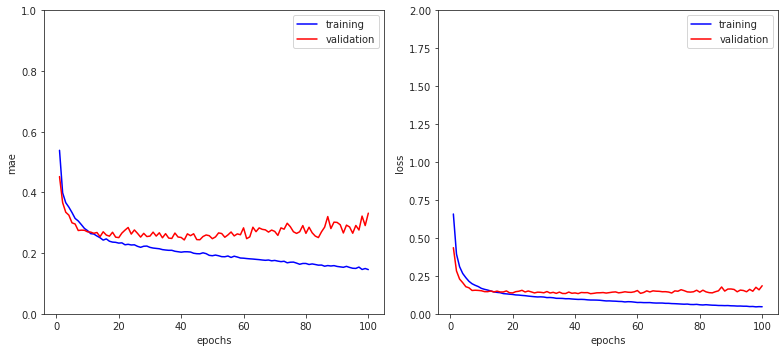

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))    

results = model_history.history

epochs = range(1,len(results['mae'])+1)

mae_values = results['mae']
val_mae_values = results['val_mae']

loss_values = results['loss']
val_loss_values = results['val_loss']

    
#mae
axs[0].plot(epochs,mae_values,color='blue',label='training',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_mae_values,color='red',label='validation',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('mae')
axs[0].set_ylim([0,1.0])   
axs[0].legend(loc='best')
    
#loss       
axs[1].plot(epochs,loss_values,color='blue',label='training',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='validation',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0,2])   
axs[1].legend(loc='best');

plt.tight_layout()

# Prospects
    1. Fight overfit (regularization/dropout)
    2. Study effects of cuts (surely my filters are not good)
    3. What to do with pop_max = 0? 
    4. Hyperparameter search of the NN (very interesting!)
    5. K-fold cross validation

# Trash (all the stuff below is a complete mess)

<IPython.core.display.Javascript object>


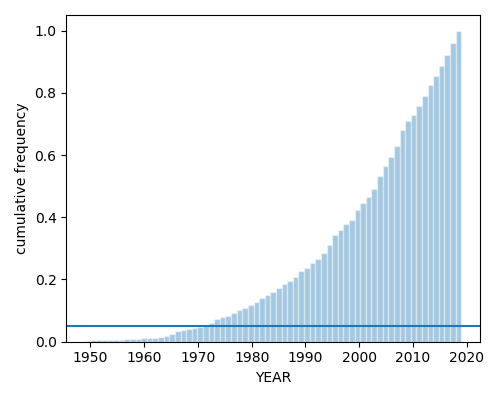

In [6]:
fig, ax = plt.subplots(figsize=(5,4))    
with sns.axes_style("ticks"):
    sns.distplot(df1['YEAR'],ax=ax,bins=len(df1['YEAR'].unique()),
                 kde=False,hist_kws={'cumulative':True},norm_hist=True)
    plt.axhline(y=0.05)
    ax.set_ylabel('cumulative frequency',fontsize=10)

    plt.tight_layout()

In [12]:
nans = pd.DataFrame(data=df2.isnull().sum(axis = 0).values,index=df2.columns,columns=['number'])
for idx in nans.index:
    print(idx,': ',nans.loc[idx].values[0])

TOTAL_HRS_norm :  0
USA_SSHS_norm :  7
V_LAND_KN_norm :  0
ln(pop_max_34_adj)_norm :  98
ln(pop_max_50_adj)_norm :  127
ln(pop_max_64_adj)_norm :  196
ln(GDP per capita (constant 2010 US$))_norm :  9
GDP growth (annual %)_norm :  23
ln(Net flows from UN agencies US$)_norm :  181
Income_level_Final_norm :  0
ln(Air transport, freight (million ton-km))_norm :  118
Arable land (hectares per person)_norm :  1
Cereal yield (kg per hectare)_norm :  9
Food production index (2004-2006 = 100)_norm :  4
Life expectancy at birth, total (years)_norm :  4
ln(TOTAL_AFFECTED)_norm :  0
ln(TOTAL_DAMAGE_(000$)_adj)_norm :  293
ln(TOTAL_DEATHS)_norm :  129


In [13]:
df1.columns

Index(['YEAR', 'ISO_TIME', 'TOTAL_HRS', 'USA_SSHS', 'V_LAND_KN',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'ISO',
       'GDP per capita (constant 2010 US$)', 'GDP growth (annual %)',
       'Net flows from UN agencies US$', 'Income_level_Final',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'Life expectancy at birth, total (years)', 'TOTAL_AFFECTED', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)_adj',
       'ln(pop_max_34_adj)', 'ln(pop_max_50_adj)', 'ln(pop_max_64_adj)',
       'ln(GDP per capita (constant 2010 US$))',
       'ln(Net flows from UN agencies US$)', 'ln(TOTAL_AFFECTED)',
       'ln(TOTAL_DAMAGE_(000$)_adj)', 'ln(TOTAL_DEATHS)', 'TOTAL_HRS_norm',
       'USA_SSHS_norm', 'V_LAND_KN_norm', 'pop_max_34_adj_norm',
       'pop_max_50_adj_norm', 'pop_max_64_adj_norm',
       'GDP per capita (co

<IPython.core.display.Javascript object>


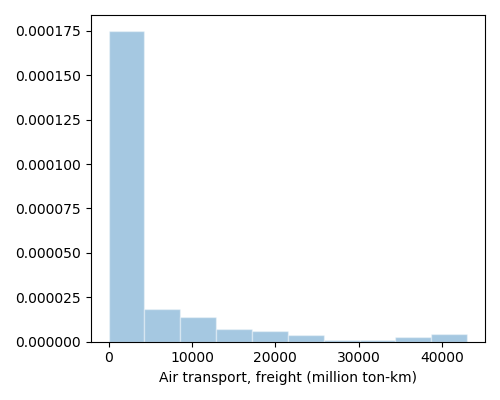

In [6]:
fig, ax = plt.subplots(figsize=(5,4))    
with sns.axes_style("ticks"):
    sns.distplot(df1['Air transport, freight (million ton-km)'],ax=ax,bins=10,
                 kde=False,hist_kws={'cumulative':False},norm_hist=True)
    #plt.axhline(y=0.05)
    #ax.set_ylabel('cumulative frequency',fontsize=10)
    #plt.xscale('log')

    plt.tight_layout()

In [42]:
df1_norm = df1_norm.iloc[:,-18:]
df1_norm

,TOTAL_HRS_norm,USA_SSHS_norm,V_LAND_KN_norm,STORM_SPD_MEAN_norm,pop_max_34_adj_norm,pop_max_50_adj_norm,pop_max_64_adj_norm,GDP per capita (constant 2010 US$)_norm,GDP growth (annual %)_norm,Net flows from UN agencies US$_norm,"Air transport, freight (million ton-km)_norm",Arable land (hectares per person)_norm,Cereal yield (kg per hectare)_norm,Food production index (2004-2006 = 100)_norm,"Life expectancy at birth, total (years)_norm",TOTAL_AFFECTED_norm,TOTAL_DAMAGE_(000$)_norm,TOTAL_DEATHS_norm
0,-1.803197,-0.778153,1.106822,-0.601957,-0.583808,-0.492914,-0.411456,-0.618944,0.200281,-0.730116,-0.511255,0.347724,-0.991923,-1.319801,-3.846349,-0.288867,-0.181468,-0.043106
1,1.044023,-0.778153,-1.149810,-0.959048,0.773397,0.209281,0.439109,-0.659535,3.570448,-0.840600,NaN,-0.187625,-0.834610,-2.731076,-1.755004,-0.286899,NaN,-0.035463
2,1.044023,2.073888,1.999789,-0.147395,-0.484998,-0.467504,-0.424278,-0.592732,-0.163050,-0.664882,-0.509523,-0.162210,-1.287725,-2.215458,-1.160357,-0.222362,-0.182663,-0.029266
3,-1.803197,2.073888,1.550298,0.622478,-0.188106,-0.118746,-0.412587,-0.592732,-0.163050,-0.664882,-0.509523,-0.162210,-1.287725,-2.215458,-1.160357,-0.081248,-0.170077,0.104799
4,0.230532,-0.207745,-0.817441,0.188221,-0.372627,-0.457881,-0.386859,-0.590743,0.236853,-0.572498,-0.508365,-0.174507,-1.333246,-2.164529,-1.155244,-0.287883,NaN,-0.049923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,-0.989706,-0.207745,-1.209953,-0.400033,NaN,NaN,NaN,-0.283206,-0.196260,-0.840600,NaN,0.154647,-0.276188,0.654091,0.783251,0.060817,NaN,-0.056120
957,-0.582960,1.503479,1.961804,-1.385323,-0.616740,-0.517295,-0.448169,-0.643301,-0.125276,-0.840600,NaN,-0.130335,0.155048,0.829589,-0.742922,-0.293245,NaN,-0.056947
958,-1.396452,1.503479,1.961804,-0.487615,-0.576538,-0.517295,-0.448169,-0.636356,-0.061080,-0.840600,NaN,0.045708,-1.589899,1.751765,-1.839232,0.444801,0.081135,0.066996
959,-1.396452,2.073888,0.936206,-0.312452,NaN,NaN,NaN,-0.585021,-0.298745,-0.840600,NaN,-0.296384,-1.285181,0.384238,-1.074472,-0.123928,NaN,-0.055914


In [18]:
test_df=df1.copy()
print(df1['V_LAND_KN'].mean(),df1['V_LAND_KN'].std())
test_df['V_LAND_KN_norm']=test_df.apply(lambda x: mean_norm(x['V_LAND_KN'],df1['V_LAND_KN'].mean(),df1['V_LAND_KN'].std()),axis=1)
#test_df

89.2240270551509 31.591322505082


In [11]:
dataset_df['ISO'].unique()

array(['JPN', 'JAM', 'PHL', 'HTI', 'MEX', 'HKG', 'VNM', 'TWN', 'BHS',
       'DOM', 'CUB', 'SLB', 'USA', 'MDG', 'HND', 'GTM', 'CHN', 'FJI',
       'AUS', 'TTO', 'BLZ', 'MUS', 'KOR', 'MOZ', 'NCL', 'COM', 'ZAF',
       'SWZ', 'TCA', 'VUT', 'NIC', 'REU', 'VIR', 'THA', 'GRD', 'WSM',
       'PNG', 'VEN', 'PRI', 'MYS', 'SLV', 'TON', 'PRK', 'RUS', 'CYM',
       'ZWE', 'CAN', 'COL', 'MMR', 'OMN', 'IRN', 'BGD', 'CRI', 'IND',
       'LAO', 'PAK', 'LKA', 'SOM', 'YEM', 'PAN', 'MAC', 'IDN', 'PRT'],
      dtype=object)

In [29]:
len(dataset_df[dataset_df['ISO']=='RUS'])

1

In [45]:
print(df1['TOTAL_HRS'].min(),df1['TOTAL_HRS'].max())
print(df1['TOTAL_HRS'].mean(),df1['TOTAL_HRS'].std())

0 23
9.901864573110894 7.394721904208477


In [19]:
print(test_df['V_LAND_KN_norm'].min(),test_df['V_LAND_KN_norm'].max())
print(test_df['V_LAND_KN_norm'].mean(),test_df['V_LAND_KN_norm'].std())

-1.8746928700317533 2.613881483801932
-4.4362709828934453e-16 1.0


In [2]:
cyclones_df = pd.read_excel('./datasets/cyclones_merged_dataset_20200414.xls')
print(list(cyclones_df.columns))
cyclones_df

['SID', 'ISO', 'NAME', 'BASIN', 'SUBBASIN', 'NATURE', 'TRACK_TYPE', 'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS', 'PRES_CALC_mean', 'STORM_SPD_mean', 'STORM_DR_mean', 'genesis_basin', 'v_land_kn', '34kn_pop', '34kn_assets', '64kn_pop', '64kn_assets', '96kn_pop', '96kn_assets', 'Year', 'Event name', 'Num homeless', 'Total affected', "Total damage ('000$)", 'CPI', 'Final_Num_Affected', 'Final_Num_Homeless', 'Final_Num_Injured']


,SID,ISO,NAME,BASIN,SUBBASIN,NATURE,TRACK_TYPE,ISO_TIME,COORDS,TOTAL_HRS,...,96kn_assets,Year,Event name,Num homeless,Total affected,Total damage ('000$),CPI,Final_Num_Affected,Final_Num_Homeless,Final_Num_Injured
0,1949163N07145,JPN,DELLA,WP,WP,ET,main,"['1949-06-20 15:00:00', '1949-06-20 18:00:00',...","[[31.99, 130.68], [33.52, 130.97], [41.0, 140....",12,...,NaN,1949,DELLA,NaN,194046.0,NaN,9.327572,194046,0,0.0
1,1949313N06137,PHL,RENA,WP,WP,TS,main,"['1949-11-11 09:00:00', '1949-11-11 15:00:00',...","[[9.49, 125.55], [9.99, 124.0], [10.3, 123.13]...",12,...,NaN,1949,RENA,NaN,NaN,NaN,9.327572,0,0,0.0
2,1950241N23140,JPN,JANE,WP,WP,TS,main,"['1950-09-03 03:00:00', '1950-09-03 06:00:00',...","[[34.94, 135.48], [36.1, 136.09], [37.27, 136....",21,...,NaN,1950,JANE,NaN,642117.0,NaN,9.431937,642117,0,0.0
3,1951119N06145,PHL,IRIS,WP,WP,TS,main,"['1951-05-04 21:00:00', '1951-05-05 00:00:00',...","[[11.99, 125.07], [12.12, 124.72], [13.73, 121...",6,...,1.283009e+10,1951,IRIS,NaN,NaN,NaN,10.175534,0,0,82.0
4,1951224N12316,JAM,CHARLIE,NAm,NAm,TS,main,"['1951-08-18 03:00:00', '1951-08-18 06:00:00']","[[17.9, -76.9], [18.1, -77.8]]",3,...,1.948346e+10,1951,CHARLIE,NaN,20200.0,56000.0,10.175534,20200,25000,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2018315N13089,IND,GAJA,NAm,NAm,NR,PROVISIONAL,"['2018-11-15 21:00:00', '2018-11-16 00:00:00',...","[[10.5, 79.8], [10.4, 79.2], [10.21, 78.4], [1...",15,...,NaN,2018,GAJA,NaN,500000.0,775000.0,98.219991,500000,0,0.0
704,2018322N12110,VNM,TORAJI,WP,WP,NR,PROVISIONAL,"['2018-11-18 06:00:00', '2018-11-18 09:00:00',...","[[11.7, 109.2], [11.9, 108.52], [12.1, 107.7],...",12,...,NaN,2018,TORAJI,NaN,10028.0,17200.0,98.219991,10028,0,28.0
705,2018349N10085,IND,PHETHAI,NAm,NAm,NR,PROVISIONAL,"['2018-12-17 09:00:00', '2018-12-17 12:00:00',...","[[17.15, 82.22], [18.0, 82.3], [18.28, 82.7]]",6,...,NaN,2018,PHETHAI,NaN,10000.0,100000.0,98.219991,10000,0,0.0
706,2018365N09113,THA,PABUK,WP,WP,NR,PROVISIONAL,"['2019-01-04 09:00:00', '2019-01-04 12:00:00',...","[[8.26, 100.12], [8.3, 99.6], [8.43, 99.21], [...",12,...,NaN,2019,PABUK,NaN,720885.0,NaN,100.000000,720885,0,0.0


In [5]:
cyclones_df['TRACK_TYPE'].unique()

array(['main', 'spur', 'PROVISIONAL'], dtype=object)

In [3]:
wb_df = pd.read_csv('./datasets/worldbank_merged_dataset_20200414.csv',sep=";")
print(list(wb_df.columns))
wb_df

['Year', 'Country Code', 'Country Name', 'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', 'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$', 'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', 'Adjusted savings: education expenditure (% of GNI)', 'Rural population (% of total population)', 'Income_level_Final']


,Year,Country Code,Country Name,"Air transport, freight (million ton-km)",Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP growth (annual %),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final
0,1949,AUS,Australia,NaN,2.879424,1083.900000,36.640000,NaN,19378.370790,0.000000e+00,70.817073,NaN,1.364565,4.981227,18.471000,High
1,1950,AUS,Australia,NaN,2.879424,1083.900000,36.640000,NaN,19378.370790,0.000000e+00,70.817073,NaN,1.364565,4.981227,18.471000,High
2,1951,AUS,Australia,NaN,2.879424,1083.900000,36.640000,NaN,19378.370790,0.000000e+00,70.817073,NaN,1.364565,4.981227,18.471000,High
3,1952,AUS,Australia,NaN,2.879424,1083.900000,36.640000,NaN,19378.370790,0.000000e+00,70.817073,NaN,1.364565,4.981227,18.471000,High
4,1953,AUS,Australia,NaN,2.879424,1083.900000,36.640000,NaN,19378.370790,0.000000e+00,70.817073,NaN,1.364565,4.981227,18.471000,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,2015,TWN,Taiwan,19805.6300,0.086784,5896.200000,135.910000,6.905317,6484.435948,5.549183e+07,75.928000,91.835388,146.057642,1.790000,44.500000,High_Middle
3546,2016,TWN,Taiwan,21304.5851,0.086243,5980.900000,139.030000,6.736675,6883.895425,4.023751e+07,76.210000,96.526617,146.850678,1.790000,43.264000,High_Middle
3547,2017,TWN,Taiwan,23323.6147,0.082047,6029.000000,133.913124,6.757008,7308.065366,3.484591e+07,76.470000,103.438421,147.674051,1.790000,42.040000,High_Middle
3548,2018,TWN,Taiwan,25256.2071,0.084961,5943.541863,136.458211,6.566974,7752.559525,5.159278e+07,76.050480,115.525812,148.348833,1.790000,40.848000,High_Middle


In [10]:
for name in df1.columns:
    if name == 'ISO' or name=='ISO_TIME':
        continue
    print('{} <= {} <= {}'.format(df1[name].min(),name,df1[name].max()))

1949 <= YEAR <= 2019
0 <= TOTAL_HRS <= 23
-4.0 <= USA_SSHS <= 5.0
30.0 <= V_LAND_KN <= 171.8
290.3009693100978 <= pop_max_34_adj <= 375852416.0
38.01658272530523 <= pop_max_50_adj <= 318955941.22566193
10.32185540948538 <= pop_max_64_adj <= 87863636.42560641
168.6639758 <= GDP per capita (constant 2010 US$) <= 56423.28506
-16.99507469 <= GDP growth (annual %) <= 19.3
9999.999776 <= Net flows from UN agencies US$ <= 183749999.5
1 <= Income_level_Final <= 4
0.0 <= Air transport, freight (million ton-km) <= 42985.29522
0.000425351 <= Arable land (hectares per person) <= 3.069372586
393.3 <= Cereal yield (kg per hectare) <= 8900.0
17.39 <= Food production index (2004-2006 = 100) <= 223.02
41.762 <= Life expectancy at birth, total (years) <= 84.68048780000002
2 <= TOTAL_AFFECTED <= 29622000
9.327572492 <= CPI <= 100.0
5.0 <= TOTAL_DAMAGE_(000$) <= 125000000.0
1.0 <= TOTAL_DEATHS <= 138366.0
0.11883674954521657 <= TOTAL_DAMAGE_(000$)_adj <= 1636382.0950154893
5.670918210019491 <= ln(pop_max_

In [7]:
wb_df['Food production index (2004-2006 = 100)'].unique()

array([36.64      , 41.52      , 43.22      , ..., 88.25794825,
       86.99071614, 87.45397905])